# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 5: Cross-Validation and Regularization

**Harvard University**<br>
**Summer 2020**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner, Kevin Rader

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Cross-Validation</li>
<li> Data Augmentation</li>    
<li> Regulatization (Ridge and Lasso)</li>
<li> Tuning the $\lambda$ parameter</li>
    

## Learning Goals

This Jupyter notebook accompanies Lecture 5. By the end of this lecture, you should be able to:

- Know how to manually perform random subsets cross-validation
- Perform $k$-fold cross-v alidation both manually and using provided libraries
- Perform both forms of regularization (Ridge and LASSO) and understand the most basic use differences


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels as sm
import statsmodels.regression.linear_model as lm

from sklearn.model_selection import KFold

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

## Part 0: Reading the data 

We will be using the same data as last week (both the train and test splits): modeling `votergap` from the 2016 election (Trump-Clinton) from many predictors in the `county_election` dataset.

We start by reading in the datasets for you and refitting some regression models from last week:

**Important note: use the training dataset for all exploratory analysis and model fitting.  Only use the test dataset to evaluate and compare models.**


In [3]:

train = pd.read_csv("../data/county_election_train.csv")
test = pd.read_csv("../data/county_election_test.csv")

#recall we log-transformed several of the variables and did a little imputation in cancer variable (with the median)
train['log_density'] = np.float64(np.log(train['density']))
train['log_minority'] = np.float64(np.log(train['minority']))
train['log_population'] = np.log(train['population'])
train['log_hispanic'] = np.log(train['hispanic'])

test['log_density'] = np.float64(np.log(test['density']))
test['log_minority'] = np.float64(np.log(test['minority']))
test['log_population'] = np.log(test['population'])
test['log_hispanic'] = np.log(test['hispanic'])

# imputing median cancer rate for the 40 or so counties with missing cancer rates
train['cancer'].loc[train['cancer'].isnull()] = np.median(train['cancer'])
test['cancer'].loc[test['cancer'].isnull()] = np.median(train['cancer'])



/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Q0.1** How were missing values imputed for the variable `cancer` in the test set?  Why was this choice made?

**Solution:**

The median of the train set was used as the imputed value on the test set.  This was done because the same value should be imputed in both sets, and the test set should not be analyzed (like calculating its median cancer rate) prior to the final step. 

In [4]:
# and we fit the simple regression model for y = votergap and x = log_density in both sklearn and statmodels

predictors = ['log_population','log_hispanic', 'log_minority', 'female', 
             'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'log_density']
X_train = train[predictors]
X_test = test[predictors]

regress_maineffects = LinearRegression(fit_intercept=True).fit(X_train, train['votergap'])

r2_test_maineffects = sk.metrics.r2_score(test['votergap'], regress_maineffects.predict(X_test))
print("R-squared on the test set for the main effects model:", r2_test_maineffects)

R-squared on the test set for the main effects model: 0.5752558339850569


In [5]:
# And then we fit a model to 

X_interact = PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(train[predictors])
print("There are", X_interact.shape[1]-2*train[predictors].shape[1]-1,"interaction terms in the design matrix for this model.")

regress_interact = LinearRegression(fit_intercept=False).fit(X_interact, train['votergap'])

r2_test_interact = sk.metrics.r2_score(test['votergap'], regress_interact.predict(
    PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(test[predictors])))
print("R-squared on the test set for the full interaction model:", r2_test_interact)

There are 55 interaction terms in the design matrix for this model.
R-squared on the test set for the full interaction model: 0.7121772296069138


In [6]:
# And lastly we did variable selection on this full model with interaction (backwards sequential variable selection)

df_backwards = pd.DataFrame(X_interact)
cutoff = 0.05

for i in np.arange(df_backwards.shape[1]):
    model_temp = lm.OLS(train['votergap'],df_backwards).fit()
    if(np.max(model_temp.pvalues) > cutoff):
        print("Predictor#:", np.argmax(model_temp.pvalues), "with associated p-value of" ,np.max(model_temp.pvalues))
        df_backwards = df_backwards.drop(df_backwards.columns[np.argmax(model_temp.pvalues)],axis=1)
    else:
        break

regress_backwards = LinearRegression(fit_intercept=False).fit(df_backwards, train['votergap'])
df_backwards.shape

X_interact_test = PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(test[predictors])
X_backwards_test = pd.DataFrame(X_interact_test)[df_backwards.columns]

r2_test_backwards = sk.metrics.r2_score(test['votergap'], regress_backwards.predict(X_backwards_test))
print("R-squared on the test set for the full interaction model:", r2_test_backwards)

Predictor#: 65 with associated p-value of 0.9809439044018047
Predictor#: 59 with associated p-value of 0.9305643717295858
Predictor#: 30 with associated p-value of 0.9249852513988832
Predictor#: 46 with associated p-value of 0.9084284356381296
Predictor#: 73 with associated p-value of 0.904567392409066
Predictor#: 5 with associated p-value of 0.8819331854474379
Predictor#: 66 with associated p-value of 0.8358331725654966
Predictor#: 67 with associated p-value of 0.8368796332970155
Predictor#: 30 with associated p-value of 0.7874028696899534
Predictor#: 56 with associated p-value of 0.7419892871253285
Predictor#: 27 with associated p-value of 0.6873645504482577
Predictor#: 51 with associated p-value of 0.7072222207250043
Predictor#: 19 with associated p-value of 0.6831101803566574
Predictor#: 1 with associated p-value of 0.4927574564274103
Predictor#: 36 with associated p-value of 0.5778097134311744
Predictor#: 56 with associated p-value of 0.4142757137247888
Predictor#: 61 with associa

In [7]:
df_backwards.columns

Int64Index([0, 2, 3, 4, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 29, 33, 37, 38, 39, 40, 41, 43, 45, 46, 48, 52, 54, 57, 58, 60, 62, 63, 64, 66, 69, 70, 72], dtype='int64')

**Q0.2** Play around with the critical p-value cut-off for keeping variables.  What does this say about using 0.05 as the cut-off?  Will this generalize to all situations?

**Solution:**

Playing around with the p-value cut-off for what should be removed does have a bearing on the predictive ability in the test set, but it there is no real pattern as to whether a higher cut-off will lower the predictive ability (at least with reasonable values for cut=-offs).  

---

## Part 1: Basic Cross-Validation

3 models were built above, and a single test-set was used to determine which was best for out-of-sample prediction.  Let's instead use cross-validation to decide which of the 3 models is best.

In [8]:
np.random.RandomState(109)

n_folds = 100
k_fold = KFold(n_folds, random_state=109, shuffle=True)
y_train = train['votergap']
X_backwards = df_backwards
X_interact = pd.DataFrame(X_interact)

r2_cv_maineffects = []
r2_cv_interact = []
r2_cv_backwards = []

for traincv_index, testcv_index in k_fold.split(X_train):
    y_traincv, y_testcv = y_train[traincv_index], y_train[testcv_index]
        
    X_maineffects_traincv, X_maineffects_testcv = X_train.loc[traincv_index], X_train.loc[testcv_index]
    X_interact_traincv, X_interact_testcv = X_interact.loc[traincv_index], X_interact.loc[testcv_index]
    X_backwards_traincv, X_backwards_testcv = X_backwards.loc[traincv_index], X_backwards.loc[testcv_index]

    model1 = LinearRegression(fit_intercept=True).fit(X_maineffects_traincv, y_traincv)
    model2 = LinearRegression(fit_intercept=True).fit(X_interact_traincv, y_traincv)
    model3 = LinearRegression(fit_intercept=True).fit(X_backwards_traincv, y_traincv)

    r2_cv_maineffects.append(sk.metrics.r2_score(y_testcv, model1.predict(X_maineffects_testcv)))
    r2_cv_interact.append(sk.metrics.r2_score(y_testcv, model2.predict(X_interact_testcv)))
    r2_cv_backwards.append(sk.metrics.r2_score(y_testcv, model3.predict(X_backwards_testcv)))

**Q1.1** Evaluate which of the 3 models considered above are best for out-of-sample prediction (both numerically and visually).  Does this agree with using the original test set?

0.5452702303377519
0.6961319116814217
0.7034500988098565


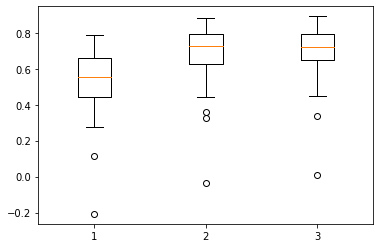

In [9]:
######
# your code here
######
print(np.mean(r2_cv_maineffects))
print(np.mean(r2_cv_interact))
print(np.mean(r2_cv_backwards))

plt.boxplot( [r2_cv_maineffects, r2_cv_interact, r2_cv_backwards])
plt.show()

**Solution:**

The results of the backwards variable selection provide the highest accuracy in the validation sets, on average (barely better than the full interaction model).  This is not 100% in agreement with the results in the test set, which favored the larger model.  The CV approach is prefered as it does not rely on a single out-of-sample set to make this decision.

**Q1.2** Play around with $k$ in the $k$-fold cross-validation above.  Does the choice of the number of folds really matter?

In [10]:
######
# your code here
######


**Solution:**

It has a bearing on the decistion, but just barely (usually the backwards model is chosen).  THe boxplots can look very different though as a larger $k$ leads to much smaller validation sets, which will have more variation in the validation scoes (especially for more complkex models).

**Q1.3** Build your own bootstrap cross-validation approach below (a skeleton is provided).  Do you see the same result comparing these 3 models?  What are the advantages to $k$-fold and random subsets/bootstrap cross-validation?

In [11]:

nboots = 1000
n_train = train.shape[0]
traincv_size = 0.8
n_traincv = int(traincv_size*n_train)

r2_cv_maineffects = []
r2_cv_interact = []
r2_cv_backwards = []

for boot in np.arange(nboots):
    random_indices = np.random.choice(n_train,n_train,replace=False)
    traincv_index = random_indices[0:n_traincv]
    testcv_index = random_indices[n_traincv:n_train]
    
    ######
    # your code here
    ######

    y_traincv, y_testcv = y_train[traincv_index], y_train[testcv_index]
        
    X_maineffects_traincv, X_maineffects_testcv = X_train.loc[traincv_index], X_train.loc[testcv_index]
    X_interact_traincv, X_interact_testcv = X_interact.loc[traincv_index], X_interact.loc[testcv_index]
    X_backwards_traincv, X_backwards_testcv = X_backwards.loc[traincv_index], X_backwards.loc[testcv_index]

    model1 = LinearRegression(fit_intercept=True).fit(X_maineffects_traincv, y_traincv)
    model2 = LinearRegression(fit_intercept=True).fit(X_interact_traincv, y_traincv)
    model3 = LinearRegression(fit_intercept=True).fit(X_backwards_traincv, y_traincv)

    r2_cv_maineffects.append(sk.metrics.r2_score(y_testcv, model1.predict(X_maineffects_testcv)))
    r2_cv_interact.append(sk.metrics.r2_score(y_testcv, model2.predict(X_interact_testcv)))
    r2_cv_backwards.append(sk.metrics.r2_score(y_testcv, model3.predict(X_backwards_testcv)))

0.5774205189013857
0.7179899238532876
0.7201583638703671


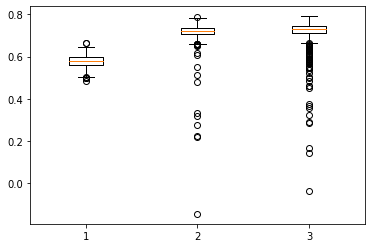

In [12]:
######
# your code here
######
print(np.mean(r2_cv_maineffects))
print(np.mean(r2_cv_interact))
print(np.mean(r2_cv_backwards))

plt.boxplot( [r2_cv_maineffects, r2_cv_interact, r2_cv_backwards])
plt.show()

**Solution:**

*k*-fold is more computationally efficient, while random subsets allows for more repetition to prevent the specific splitting having a bearing on choosing the 'best' model (without making the validation sets too small).

## Part 2: Data augmentation

In this section, we will create two different desgin matrices that will be used going forward for applying reularization to.  The first is a high-order (10) polynomial regression using `log-minority` only, and the second is a high-dimensional design matrix considering all factors.

In [13]:
X_minority_poly = PolynomialFeatures(10, include_bias=False).fit_transform(train[['log_minority']])

regress_minority_poly = LinearRegression(fit_intercept=True).fit(X_minority_poly , train['votergap'])
print("Beta0 =", regress_minority_poly.intercept_ ,", Beta1 =", regress_minority_poly.coef_)



Beta0 = 49.88978109045479 , Beta1 = [-4.64511848e+01  5.23827603e+02 -1.55326949e+03  2.14445845e+03
 -1.65982330e+03  7.75552496e+02 -2.23689633e+02  3.89969960e+01
 -3.77156604e+00  1.55527614e-01]


**Q2.1** Plot the predicted curves on top of the scatterplot of `votergap` vs. `log_minority`.  What do you notice?



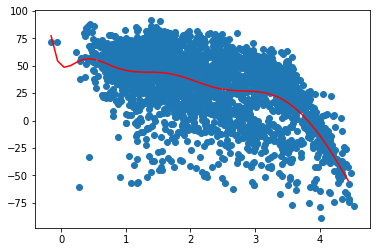

In [14]:
######
# your code here
######

x_dummy = np.arange(np.min(train['log_minority']),np.max(train['log_minority']),0.1)
yhat_minority_poly = regress_minority_poly.predict(PolynomialFeatures(10, include_bias=False).fit_transform(pd.DataFrame(x_dummy)))

plt.scatter(train['log_minority'],train['votergap'])
plt.plot(x_dummy,yhat_minority_poly,c="r",label="Poly(3) Regression")

plt.show()

In [15]:
regress_minority_poly.coef_

array([-4.64511848e+01,  5.23827603e+02, -1.55326949e+03,  2.14445845e+03,
       -1.65982330e+03,  7.75552496e+02, -2.23689633e+02,  3.89969960e+01,
       -3.77156604e+00,  1.55527614e-01])

**Solution:**

The prediction curve is more *wiggly* than ideally we'd see: there is too much overfitting to the two smallest points on the x-axis (`log-minority`), for example.  This model is likely too complex (and thus overfit to this training set).

**Q2.2** Create a design matrix (call it `X_over`) with all the interactions and 4th-order polynomials based on the original list of 11 predictors: 

predictors = ['log_population','log_hispanic', 'log_minority', 'female', 
             'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'log_density']

How many predictors does this create?  Justify this number mathematically (it is not easy).

In [16]:
######
# your code here: create X_over 
######

X_over = PolynomialFeatures(4, include_bias=False).fit_transform(X_train)
X_over_test = PolynomialFeatures(4, include_bias=False).fit_transform(X_test)
X_over.shape


(2620, 1364)

**Solution:**

We need to add up:
- all the polynomial terms (linear, 2nd order, 3rd order, and 4th order): $4\cdot11$
- all the 2-way interactions $\binom{11}{2}$
- all the 2-way interactions involving (2nd order term or 3rd order term) with a linear term: $2\times2\times \binom{11}{2}$
- all the 2-way interactions involving two 2nd order terms: $\binom{11}{2}$
- all the 3-way interactions of linear terms $\binom{11}{3}$
- all the 3-way interactions involving two linear terms and a quadratic term $\binom{11}{3}$
- all the 4-way interactions $\binom{11}{4}$


$$  \binom{11}{4} + 2\times\binom{11}{3} + 6\times\binom{11}{2} + 4\times11 = 1364 $$

**Q2.2** Fit the model using the over-parameterized design matrix above.  How does it perform on the test set?

In [17]:
######
# your code here
######

regress_over = LinearRegression(fit_intercept=True).fit(X_over , train['votergap'])

r2_test_over = sk.metrics.r2_score(test['votergap'], regress_over.predict(X_over_test))
print("R-squared on the test set for the overparameterized model:", r2_test_over)

R-squared on the test set for the overparameterized model: 0.6880555051576484


## Part 3: Regularization: Ridge and LASSO

In this part we will explore the effects of regularization on linear regression modeling.  First using the 20th order polynomial version of log_minority, then using the over-parameterized design matrix.


**Q3.1** Fit a Ridge model with $\alpha = 1$, $\alpha = 10$, and a LASSO model with $\alpha = 1$, and $\alpha = 10$ using the `X_minority_poly` design matrix.  Compare the estimated coefficients for all 5 models.

In [18]:
######
# your code here
######

ridge_alpha1 = Ridge(alpha=1,fit_intercept=True).fit(X_minority_poly , train['votergap'])
print("Beta0 =", ridge_alpha1.intercept_ ,", Beta1 =", ridge_alpha1.coef_)

ridge_alpha10 = Ridge(alpha=10,fit_intercept=True).fit(X_minority_poly , train['votergap'])
print("Beta0 =", ridge_alpha10.intercept_ ,", Beta1 =", ridge_alpha10.coef_)

lasso_alpha1 = Lasso(alpha=1,fit_intercept=True,max_iter=1000).fit(X_minority_poly , train['votergap'])
print("Beta0 =", lasso_alpha1.intercept_ ,", Beta1 =", lasso_alpha1.coef_)

lasso_alpha10 = Lasso(alpha=10,fit_intercept=True,max_iter=1000).fit(X_minority_poly , train['votergap'])
print("Beta0 =", lasso_alpha10.intercept_ ,", Beta1 =", lasso_alpha10.coef_)



Beta0 = 64.49391340443822 , Beta1 = [-18.95025409 -10.44028038   6.5911364   12.71504456  -1.8300944
 -13.33393945  10.39011724  -3.2879733    0.48514588  -0.02761048]
Beta0 = 55.687220405983 , Beta1 = [-7.20513141 -3.58390422  1.66582024  3.41883306 -0.64999257 -3.86903538
  3.07861478 -0.96055355  0.13609343 -0.00726394]
Beta0 = 47.8662802219242 , Beta1 = [-0.00000000e+00 -0.00000000e+00 -1.55562338e+00 -0.00000000e+00
  9.96573366e-02  2.90183115e-03 -1.27744199e-03 -4.14217986e-04
 -7.01457702e-05 -5.22183073e-06]
Beta0 = 44.65322074370791 , Beta1 = [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -3.52536842e-01
 -1.22219814e-02  1.26846239e-02  3.50116987e-03 -5.30478813e-05
 -1.10089285e-04 -2.76704521e-05]


/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 836606.9266897946, tolerance: 249.90114090421835
  positive)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 784651.3499429179, tolerance: 249.90114090421835
  positive)


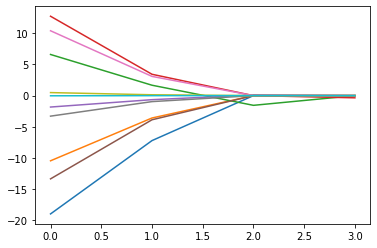

In [19]:
plt.plot([ridge_alpha1.coef_,ridge_alpha10.coef_,lasso_alpha1.coef_,lasso_alpha10.coef_])
plt.show()

**Solution:**

Here we see the coefficients are shrunken the most with LASSO, and within either Ridge or LASSO, the larger the value for $\alpha$ the more shrinking towards zero results.  Note: the OLS estimates were let off since they would have dominated the magnitudes of these estimates and made them all appear to be zero.

**Q3.3**  Plot the predictions (on top of the scatterplot) for all 5 models.  What do you notice?

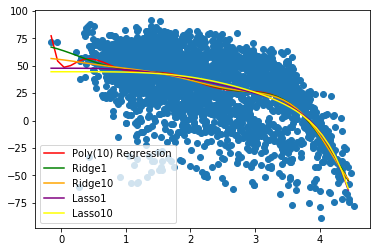

In [20]:
######
# your code here
######
x_dummy_poly10 = PolynomialFeatures(10, include_bias=False).fit_transform(pd.DataFrame(x_dummy))
yhat_minority_poly = regress_minority_poly.predict(x_dummy_poly10)
yhat_ridge1 = ridge_alpha1.predict(x_dummy_poly10)
yhat_ridge10 = ridge_alpha10.predict(x_dummy_poly10)
yhat_lasso1 = lasso_alpha1.predict(x_dummy_poly10)
yhat_lasso10 = lasso_alpha10.predict(x_dummy_poly10)


plt.scatter(train['log_minority'],train['votergap'])
plt.plot(x_dummy,yhat_minority_poly,c="r",label="Poly(10) Regression")
plt.plot(x_dummy,yhat_ridge1,c="green",label="Ridge1")
plt.plot(x_dummy,yhat_ridge10,c="orange",label="Ridge10")
plt.plot(x_dummy,yhat_lasso1,c="purple",label="Lasso1")
plt.plot(x_dummy,yhat_lasso10,c="yellow",label="Lasso10")
plt.legend()

plt.show()

**Solution:**

This shows that all of the 4 penalized models smooth out the 10$^{th}$ order polynomial similarly, but the LASSOs are smoothed out more than the ridges (due to many of the polynomial term coefficients being much smaller in magnitude).


**Q3.3** For Ridge, *tune* the penalty terms using the test set.  Which value did you choose? How does this perform on the test set?

In [21]:
######
# your code here
######

alphas = np.exp(np.arange(-10,10,1))
r2_ridges_test = []
X_minority_poly_test = PolynomialFeatures(10, include_bias=False).fit_transform(test[['log_minority']])

for alpha in alphas:
    ridge = Ridge(alpha=alpha,fit_intercept=True).fit(X_minority_poly , train['votergap'])
    r2_ridges_test.append(sk.metrics.r2_score(test['votergap'], ridge.predict(X_minority_poly_test)))



print(alphas[np.argmax(r2_ridges_test)])  


20.085536923187668


/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41308e-19): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.53883e-19): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.60109e-19): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.49387e-18): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.77084e-18): result may not be accurat

In [22]:
np.log(alphas[np.argmax(r2_ridges_test)])

3.0

Ignoring the warning signs, the best chosen penalty term of those considered is $e^3 = 20.08$ using the test set to choose between these models.


## Part 4: Ridge and LASSO with CV

In this part we will use cross-validation to *tune* the penalization term ($\alpha$) in both ridge and LASSO regressions for the 

**Q4.1** Use [ridgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) and [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) to tune the models using 5-fold cross-validation for the 10$^{th}$ order polynomial of `log_minority`.  You may need to play around with the values of $\alpha$ you should consider. 

In [23]:
######
# your code here
######

alphas = np.exp(np.arange(-10,20,1))
ridges = RidgeCV(alphas=alphas,fit_intercept=True,cv=5).fit(X_minority_poly, train['votergap'])

lassos = LassoCV(alphas=alphas,fit_intercept=True,cv=5).fit(X_minority_poly, train['votergap'])


/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.07293e-19): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.30585e-19): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.08102e-19): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70901e-19): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33538e-19): result may not be accurat

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3595.1768582849763, tolerance: 190.24578967661813
  tol, rng, random, positive)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37238.07092188508, tolerance: 190.24578967661813
  tol, rng, random, positive)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1806.110003523063, tolerance: 190.24578967661813
  tol, rng, random, positive)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_

In [24]:
print("R-sq on test for Ridge:",ridges.score(X_minority_poly_test, test['votergap']))
print("Best Ridge Model: Intercept =",ridges.intercept_ , "Coefficients =",ridges.coef_)
ridges.alpha_

R-sq on test for Ridge: 0.30560000540602017
Best Ridge Model: Intercept = 48.080962294251094 Coefficients = [-0.06930236 -0.12984712 -0.19618995 -0.25335745 -0.25323136 -0.12940294
  0.07688495  0.04696065 -0.02388128  0.00260426]


8103.083927575384

In [25]:
print("R-sq on test for LASSO:",lassos.score(X_minority_poly_test, test['votergap']))
print("Best LASSO Model: Intercept =",lassos.intercept_ , "Coefficients =",lassos.coef_)
lassos.alpha_

R-sq on test for LASSO: 0.3118319090485964
Best LASSO Model: Intercept = 56.31513616494624 Coefficients = [-5.73152186e+00 -3.21496974e+00  3.82776917e-01  1.43781863e-01
  4.65974255e-03 -3.50946675e-03 -1.25860459e-03 -2.61655789e-04
 -3.23441547e-05  1.86085330e-06]


0.049787068367863944

**Q4.2** How do the best choices of $\alpha$ compare for Ridge and LASSO?  Why is this not surprising, mathematically?

**Solution:**

The value for $\alpha$ is much smaller for LASSO than Ridge.  This is simply due to the fact that the way `sklearn` has implemented these penalty terms is not standard, as LASSO penalizes MSE while Ridge penalizes SSE in sklearn (see documentation [here](https://scikit-learn.org/stable/modules/linear_model.html)).  They are not comparable to each other since they are using different units (Ridge is in squared units, LASSO in standard units).

**Q4.3** Why is it important to not include the bias term when creating the design matrices?  Why is it important to standardize the predictors?  Were these precautions taken here?

**Solution:**

Bias (the intercept) chould not be included in the penalty term because the default model should be the one with just the intercept when all the other $\beta$ coefficient estimates are *shrunk* to zero.  This equates to using $\bar{y}$ as the best prediction model (see below).

Standardizing the predictors leads to putting them all on the same scale (where 1 unit is 1 standard deviation).  Thus the units of the predictors will not have an effect on how they are shrunk relative to one another (predictors with smaller standard deviations would be shrunk quicker if not standardized).  This precaution was not done here.


In [26]:
print(Ridge(alpha=10**24,fit_intercept=True).fit(X_minority_poly , train['votergap']).intercept_)
print(np.mean(train['votergap']))

31.861961834352066
31.861961832061073


**Q4.4** Fit a well-tuned regularization model on the overly parameterized design matrix `X_over`.  How does this perform on the test set?

In [27]:
######
# your code here
######

alphas = np.exp(np.arange(-10,20,1))
ridges_over = RidgeCV(alphas=alphas,fit_intercept=True,cv=5).fit(X_over, train['votergap'])


/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.10499e-47): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.81289e-47): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.3307e-47): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.21436e-47): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10235e-46): result may not be accurate

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.2551e-43): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30683e-43): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.5933e-43): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.39966e-43): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.05496e-43): result may not be accurate.

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.68013e-40): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.0111e-40): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.18512e-40): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.34559e-40): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.95341e-40): result may not be accurate

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.62062e-37): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.71129e-37): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.59985e-37): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.11674e-36): result may not be accurate.
  overwrite_a=True).T
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.39228e-36): result may not be accurat

In [28]:
print("R-sq on test for Ridge:",ridges_over.score(X_over_test, test['votergap']))

R-sq on test for Ridge: 0.7051913303423255


**Solution:**

After choosing the best model based on the Ridge penalty term, this model performs better (0.705 vs. 0.688 unpenalized).  A similar approach coudl be used with LASSO CV.
